In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.data_loader import *

In [53]:
categories = read_categories()
categories.head(3)

,article,category,level_1,level_2,level_3
0,Áedán mac Gabráin,subject.History.British_History.British_Histor...,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán mac Gabráin,subject.People.Historical_figures,People,Historical_figures,None
2,Åland,subject.Countries,Countries,None,None


In [16]:
# Assign Weights
level_weights = {
    'level_1': 3,
    'level_2': 2,
    'level_3': 1
}

categories['weight'] = (
    categories['level_1'].apply(lambda x: level_weights['level_1']) +
    categories['level_2'].apply(lambda x: level_weights['level_2'] if pd.notnull(x) else 0) +
    categories['level_3'].apply(lambda x: level_weights['level_3'] if pd.notnull(x) else 0)
)

# Create pivot table
category_pivot = categories.pivot_table(
    index='article',
    columns='category',
    values='weight',
    aggfunc='max',
    fill_value=0
)

print("Category Pivot Table Sample:")
print(category_pivot.head())

# ------------------------------
# Step 2: Optimized Weighted Jaccard Similarity
# ------------------------------

# Convert pivot table to NumPy array
A = category_pivot.values  # Shape: (n_articles, n_categories)

# Number of articles
n = A.shape[0]

# Initialize similarity matrix
similarity_weighted_jaccard = np.zeros((n, n))

# Compute similarity using vectorized operations with progress bar
for i in tqdm(range(n), desc="Computing Weighted Jaccard Similarity"):
    # Compute min and max with all other articles
    min_vals = np.minimum(A[i], A)
    max_vals = np.maximum(A[i], A)
    
    # Sum over categories to get intersection and union
    intersection = min_vals.sum(axis=1)
    union = max_vals.sum(axis=1)
    
    # Compute similarity, handling division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        similarity = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=union != 0)
    
    similarity_weighted_jaccard[i] = similarity

# Convert to DataFrame
similarity_weighted_jaccard_df = pd.DataFrame(
    similarity_weighted_jaccard,
    index=category_pivot.index,
    columns=category_pivot.index
)

# Display a sample of the similarity matrix
print("Optimized Weighted Jaccard Similarity Sample:")
print(similarity_weighted_jaccard_df.head())

Category Pivot Table Sample:
category      subject.Art.Art  subject.Art.Artists  \
article                                              
1 Ceres                     0                    0   
10th century                0                    0   
11th century                0                    0   
12th century                0                    0   
13th century                0                    0   

category      subject.Business_Studies.Business  \
article                                           
1 Ceres                                       0   
10th century                                  0   
11th century                                  0   
12th century                                  0   
13th century                                  0   

category      subject.Business_Studies.Companies  \
article                                            
1 Ceres                                        0   
10th century                                   0   
11th century              

Computing Weighted Jaccard Similarity: 100%|██████████| 4598/4598 [00:32<00:00, 143.26it/s]

Optimized Weighted Jaccard Similarity Sample:
article       1 Ceres  10th century  11th century  12th century  13th century  \
article                                                                         
1 Ceres           1.0           0.0           0.0           0.0           0.0   
10th century      0.0           1.0           1.0           1.0           1.0   
11th century      0.0           1.0           1.0           1.0           1.0   
12th century      0.0           1.0           1.0           1.0           1.0   
13th century      0.0           1.0           1.0           1.0           1.0   

article       14th century  15th Marine Expeditionary Unit  15th century  \
article                                                                    
1 Ceres                0.0                             0.0           0.0   
10th century           1.0                             0.0           1.0   
11th century           1.0                             0.0           1.0   
12th c

Text(0.5, 1.0, 'Similarity of article categories')

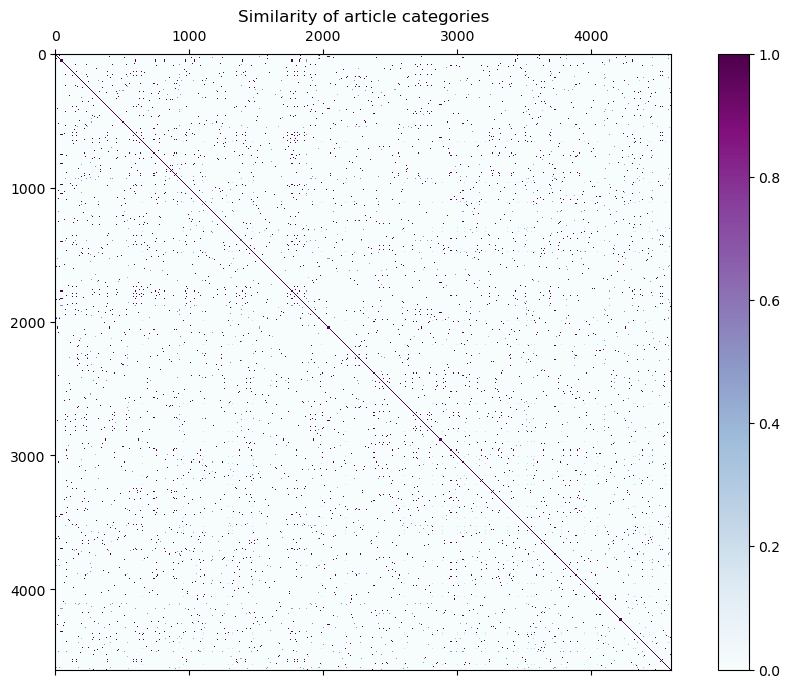

In [23]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(similarity_weighted_jaccard_df, cmap='BuPu')
cbar = fig.colorbar(cax)
plt.title('Similarity of article categories')

# Clusters

PCA Explained Variance Ratio:
[0.01531741 0.01198842 0.01085639 0.00969214 0.00930494 0.0092063
 0.00914057 0.00910658 0.00901532 0.00886238 0.00881547 0.00878679
 0.00872684 0.00869461 0.00865109 0.00863413 0.0086233  0.00856744
 0.00850734 0.00847927 0.0084676  0.00840314 0.00836221 0.00834699
 0.00833724 0.00827824 0.00825053 0.0082285  0.00819928 0.00816226
 0.0081267  0.00810855 0.00809462 0.00807506 0.00805458 0.00804411
 0.00803698 0.00801886 0.00799819 0.00799134 0.00798794 0.00796222
 0.00793763 0.00793139 0.00791525 0.00788488 0.00786908 0.00785757
 0.00785171 0.0078462  0.00784045 0.00783543 0.00782831 0.00782413
 0.00782175 0.00781383 0.00780649 0.00779984 0.00779618 0.00779567
 0.00779384 0.00779312 0.00779192 0.00779067 0.00778883 0.00778824
 0.00778767 0.00778519 0.0077824  0.00778229 0.00778121 0.00778
 0.00777901 0.00777901 0.00777783 0.00777731 0.00777691 0.00777671
 0.00777581 0.00777334]


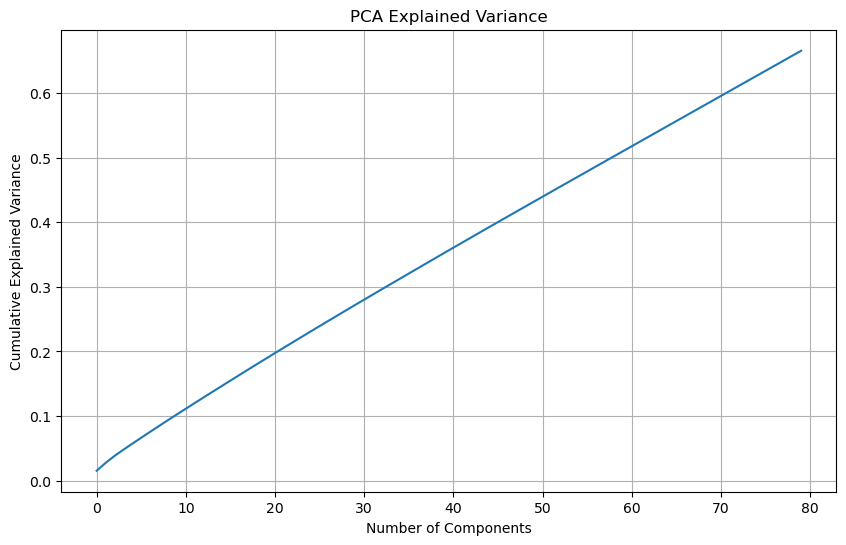

In [43]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Assume 'similarity_weighted_jaccard_df' is your similarity matrix DataFrame
# Ensure it's loaded and accessible

# Step 1: Convert Similarity to Distance
distance_matrix = 1 - similarity_weighted_jaccard_df

# Step 2: Feature Extraction via PCA
# Since K-Means requires feature vectors, we need to embed the distance matrix
# One approach is to use Multi-Dimensional Scaling (MDS), but it's computationally heavy
# Instead, we can perform PCA on the original pivot table

# Alternative Approach: Use the original category_pivot for PCA
# This avoids the computational burden of embedding from the distance matrix

# Standardize the data
scaler = StandardScaler()
category_pivot_scaled = scaler.fit_transform(category_pivot)

# Apply PCA
pca = PCA(n_components=80, random_state=42)  # Adjust n_components as needed
pca_result = pca.fit_transform(category_pivot_scaled)

# Convert PCA result to DataFrame
pca_df = pd.DataFrame(pca_result, index=category_pivot.index,
                      columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

print("PCA Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Optional: Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

Evaluating K-Means Clusters: 100%|██████████| 19/19 [00:14<00:00,  1.32it/s]


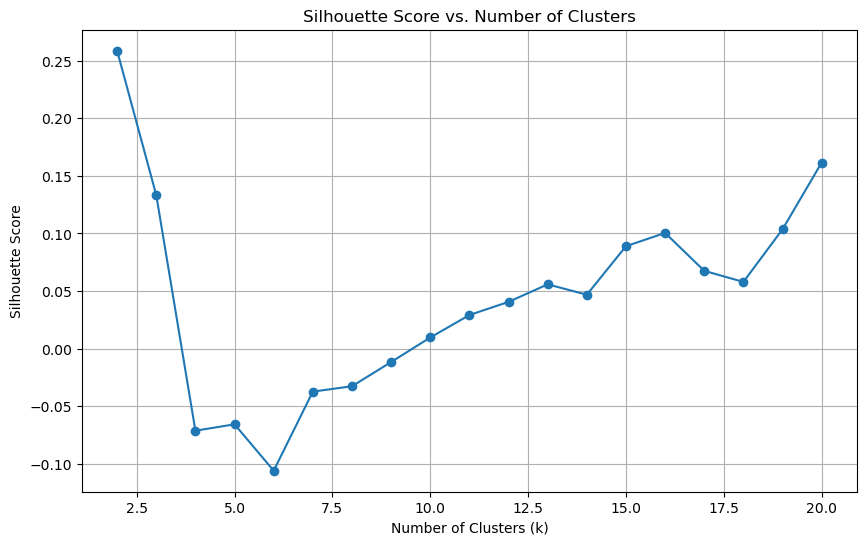

Optimal number of clusters (k): 2


In [44]:
from sklearn.metrics import silhouette_score

# Define range for k
k_values = range(2, 21)  # Adjust as needed

# Store silhouette scores
silhouette_scores = []

for k in tqdm(k_values, desc="Evaluating K-Means Clusters"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(pca_df)
    score = silhouette_score(pca_df, cluster_labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(10,6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

# Identify optimal k
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (k): {optimal_k}")


In [49]:
# Assuming optimal_k is determined from the previous step
k = optimal_k

# Initialize K-Means
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

# Fit and predict cluster labels
cluster_labels = kmeans.fit_predict(pca_df)

# Add cluster labels to the PCA DataFrame
pca_df['Cluster'] = cluster_labels

# Display cluster distribution
print(pca_df['Cluster'].value_counts())

Cluster
1    2581
0    2017
Name: count, dtype: int64


In [50]:
# Compute Silhouette Score
score = silhouette_score(pca_df.drop('Cluster', axis=1), pca_df['Cluster'])
print(f"Silhouette Score for k={k}: {score:.4f}")

# Compute WCSS
wcss = kmeans.inertia_
print(f"Within-Cluster Sum of Squares (WCSS) for k={k}: {wcss:.4f}")


Silhouette Score for k=2: 0.2406
Within-Cluster Sum of Squares (WCSS) for k=2: 1095921.3248


c:\Users\david\anaconda3\envs\ada\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


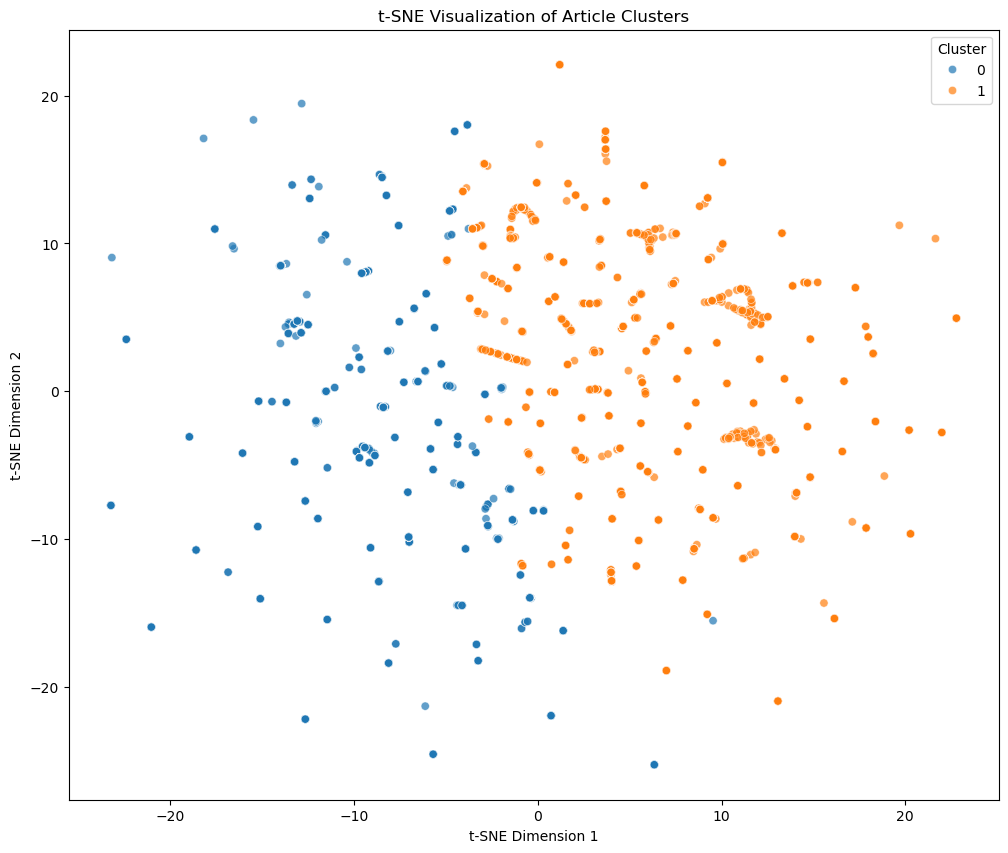

In [51]:
from sklearn.manifold import TSNE

# Apply t-SNE on PCA-reduced data
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(pca_df.drop('Cluster', axis=1))

# Add t-SNE results to DataFrame
pca_df['TSNE1'] = tsne_results[:,0]
pca_df['TSNE2'] = tsne_results[:,1]

# Plot t-SNE
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='Cluster',
    palette='tab10',
    data=pca_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE Visualization of Article Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.show()


In [52]:
# Merge cluster labels with original data
clusters = pca_df['Cluster'].reset_index()
clustered_data = categories.merge(clusters, on='article')

# Example: Top categories per cluster
for cluster in sorted(clustered_data['Cluster'].unique()):
    print(f"\nCluster {cluster}:")
    top_categories = clustered_data[clustered_data['Cluster'] == cluster]['category'].value_counts().head(10)
    print(top_categories)



Cluster 0:
category
subject.Science.Biology.Birds                      161
subject.Science.Chemistry.Chemical_elements        119
subject.Science.Biology.Mammals                    114
subject.Science.Biology.Health_and_medicine        105
subject.Science.Physics.Space_Astronomy            102
subject.Everyday_life.Food_and_agriculture          96
subject.Design_and_Technology.Railway_transport     84
subject.Geography.European_Geography                82
subject.Geography.African_Geography                 79
subject.History.General_history                     77
Name: count, dtype: int64

Cluster 1:
category
subject.Countries                                                                          229
subject.Geography.Geography_of_Great_Britain                                               123
subject.People.Historical_figures                                                          104
subject.Geography.North_American_Geography                                                  99
su